# First Year Project

## Project Description

<hr>

### Imports and Constants

In [189]:
# Std
from pathlib import Path
import csv
import json
import platform
from IPython.display import display as d

# Array manipulation
import numpy as np
import pandas as pd


# Statistics
from scipy.stats import chi2_contingency

# Plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Visual
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

%run -i ../scripts/functions.py

Loaded functions.



In [190]:
# Logging levels
LOG = True

# Data paths
PATH = {
    'raw': Path('../data/raw/'),
    'processed': Path('../data/processed/'),
    'interim': Path('../data/interim/'),
    'references': Path('../references')
}

# Raw paths
PATH['raw_accident'] = PATH['raw'] / "Road Safety Data - Accidents 2019.csv"
PATH['raw_casual'] = PATH['raw'] / "Road Safety Data - Casualties 2019.csv"
PATH['raw_vehicles'] = PATH['raw'] / "Road Safety Data- Vehicles 2019.csv"

# Interim paths
PATH['accident'] = PATH['interim'] / "bradford_accidents.csv"
PATH['casual'] = PATH['interim'] / "bradford_casualties.csv"
PATH['vehicles'] = PATH['interim'] / "bradford_vehicles.csv"

# Ref paths
PATH['var_lookup'] = PATH['references'] / 'variable lookup.xls'

# Get all varibles and fields from the reference paper
VAR = pd.read_excel(PATH['var_lookup'], sheet_name = None, index_col = 0)

VAR = {k.replace(' ', '_'): v for k,v in VAR.items()}

<hr>

## Task 0 - Data filtering and cleaning

Most of our data filtering and cleaning happends from scripts we wrote,
which takes in the raw files as input and process them to only show bradford.

They can be run from the terminal or here. It's in src/scripts.

Pandas can handle and process datasets even though they're missing.
We're categorizing missing values as N/A.

In [191]:
# Process raw files into bradford files with pandas(pd)
# Depends on paths from this notebook, so run for here or alter to be independant.
%run -i ../src/scripts/process_bradford_in.py

In [192]:
DATA = {}

# Read data and explicitly define some data types for columns.
# The datasets are saved in utf8 with bom, so we need utf-8-sig encoding.
# We treat explicit -1 from the datasets as NA because it's their definition from the documentation.

DATA['accident'] = pd.read_csv(PATH['accident'], dtype={0: 'string', 31: 'string'}, encoding='utf-8-sig', na_values="-1")
DATA['casual'] = pd.read_csv(PATH['casual'], dtype={0: 'string'}, encoding='utf-8-sig', na_values="-1")
DATA['vehicles'] = pd.read_csv(PATH['vehicles'], dtype={0: 'string'}, encoding='utf-8-sig', na_values="-1")

<hr>

In [193]:
# Missing values overview

# Quick overview
DATA['accident'].isna().any()

# Get only the names of the columns with missing values: Time, Junction_Control and 2nd_Road_Class
DATA['accident'].columns[DATA['accident'].isna().any()]

# Pandas: first sum the missing values row-wise, then sum all the row-wise sums to one single sum
# Missing                            Not missing
DATA['accident'].isna().sum().sum(), DATA['accident'].notna().sum().sum()

# Return the rows with missing values
# We use d() to display multiple elements
d(DATA['accident'][DATA['accident']['Time'].isna()])
d(DATA['accident'][DATA['accident']['Junction_Control'].isna()]['Junction_Control'])
d(DATA['accident'][DATA['accident']['2nd_Road_Class'].isna()]['Junction_Control'])

Accident_Index  Location_Easting_OSGR  Location_Northing_OSGR  Longitude  \
17   20191361B0976               414503.0                433645.0  -1.781298   
166  20191363F1887               415444.0                430869.0  -1.767150   
812  2019136CI1516               415080.0                437637.0  -1.772344   

      Latitude  Police_Force  Accident_Severity  Number_of_Vehicles  \
17   53.798925            13                  3                   2   
166  53.773948            13                  3                   2   
812  53.834788            13                  3                   1   

     Number_of_Casualties        Date  ...  Pedestrian_Crossing-Human_Control  \
17                      1  11/01/2019  ...                                  0   
166                     1  15/03/2019  ...                                  0   
812                     1  18/12/2019  ...                                  0   

    Pedestrian_Crossing-Physical_Facilities  Light_Conditions  \
17                                        0                 1   
166                                       0                 4   
812                                       0                 4   

    Weather_Conditions  Road_Surface_Conditions  Special_Conditions_at_Site  \
17                   1                        1                           0   
166                  2                        2                           0   
812                  1                        2                           0   

     Carriageway_Hazards  Urban_or_Rural_Area  \
17                     0                    1   
166                    0                    1   
812                    0                    1   

     Did_Police_Officer_Attend_Scene_of_Accident  LSOA_of_Accident_Location  
17                                             1                  E01010812  
166                                            1                  E01010740  
812                                            1                  E01010782  

[3 rows x 32 columns]

1     NaN
4     NaN
5     NaN
6     NaN
8     NaN
       ..
821   NaN
825   NaN
826   NaN
827   NaN
830   NaN
Name: Junction_Control, Length: 341, dtype: float64

1     NaN
4     NaN
5     NaN
6     NaN
8     NaN
       ..
821   NaN
825   NaN
826   NaN
827   NaN
830   NaN
Name: Junction_Control, Length: 341, dtype: float64

## Task 1 - Single variable analysis

In [194]:
# Age analysis
pd.concat([VAR['Age_Band'], DATA['casual']['Age_Band_of_Casualty'].value_counts()], axis=1)


label  Age_Band_of_Casualty
-1   Data missing or out of range                   NaN
 1                          0 - 5                  37.0
 2                         6 - 10                  42.0
 3                        11 - 15                  75.0
 4                        16 - 20                 161.0
 5                        21 - 25                 141.0
 6                        26 - 35                 176.0
 7                        36 - 45                 170.0
 8                        46 - 55                 149.0
 9                        56 - 65                  85.0
 10                       66 - 75                  49.0
 11                       Over 75                  32.0

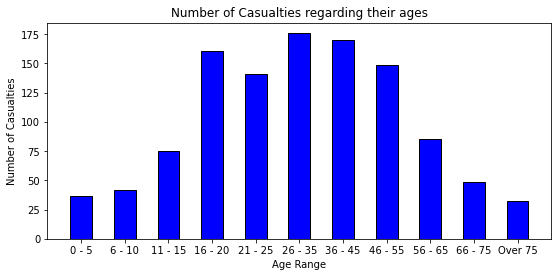

In [267]:
Age=VAR['Age_Band']['label'][:11]
Numbers=DATA['casual']['Age_Band_of_Casualty'].value_counts(sort=False)


fig = plt.figure(figsize=(7, 3))
axes = fig.add_axes([0, 0, 1, 1])
plt.bar(Age, Numbers,width=0.5, color='blue', edgecolor='black')
axes.set_ylabel('Number of Casualties');axes.set_xlabel('Age Range');axes.set_title('Number of Casualties regarding their ages');

In [196]:
# Time analysis
pd.concat([VAR['Day_of_Week'], DATA['accident']['Day_of_Week'].value_counts()], axis=1)

label  Day_of_Week
1     Sunday           88
2     Monday          111
3    Tuesday          122
4  Wednesday          135
5   Thursday          139
6     Friday          129
7   Saturday          109

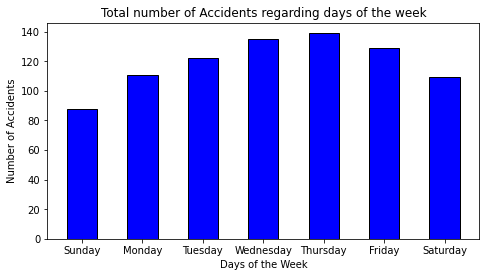

In [265]:
Weekdays=VAR['Day_of_Week']['label']
Numbers=DATA['accident']['Day_of_Week'].value_counts(sort=False)
    
    
fig = plt.figure(figsize=(6, 3))
axes = fig.add_axes([0, 0, 1, 1])
plt.bar(Weekdays, Numbers,width=0.5, color='blue', edgecolor='black')
axes.set_ylabel('Number of Accidents');axes.set_xlabel('Days of the Week');axes.set_title('Total number of Accidents regarding days of the week');

In [10]:
# Movement analysis - Task 1, c
pd.concat([VAR['Ped_Movement'], DATA['casual']['Pedestrian_Movement'].value_counts()], axis=1)

label  Pedestrian_Movement
-1                       Data missing or out of range                  NaN
 0                                   Not a Pedestrian                873.0
 1                    Crossing from driver's nearside                 98.0
 2  Crossing from nearside - masked by parked or s...                 20.0
 3                     Crossing from driver's offside                 50.0
 4  Crossing from offside - masked by  parked or s...                 13.0
 5  In carriageway, stationary - not crossing  (st...                  9.0
 6  In carriageway, stationary - not crossing  (st...                  3.0
 7       Walking along in carriageway, facing traffic                  5.0
 8      Walking along in carriageway, back to traffic                  1.0
 9                                   Unknown or other                 45.0

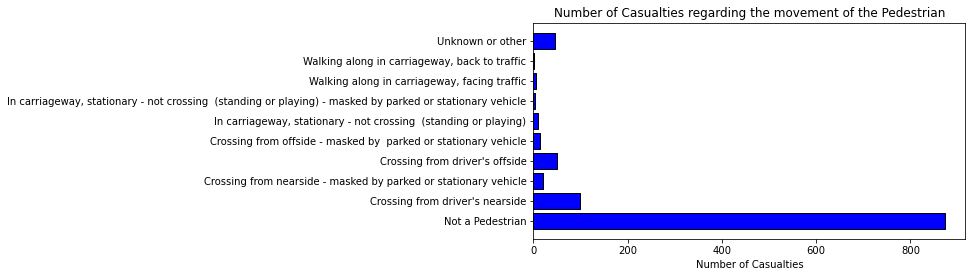

In [266]:
PedMove=VAR['Ped_Movement']['label'][:10]
Numbers=DATA['casual']['Pedestrian_Movement'].value_counts(sort=False)

fig = plt.figure(figsize=(6, 3))
axes = fig.add_axes([0, 0, 1, 1])
plt.barh(PedMove, Numbers, color='blue', edgecolor='black')
axes.set_xlabel('Number of Casualties');axes.set_title('Number of Casualties regarding the movement of the Pedestrian');

<hr>

## Task 2: Associations

<hr>

## Task 3: Map visualization

In [10]:
with open(PATH["processed"] / "citieslad.json") as f:
    cities_json = json.load(f)

# cities_json['Bradford']

In [26]:
latlon = pd.concat([DATA["accident"]['Latitude'], DATA["accident"]['Longitude']], axis=1)

centroid = list(MultiPoint(latlons).centroid.coords)[0]

m1 = folium.Map(centroid, zoom_start=11)

for i, row in DATA["accident"].iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
        radius = 5,
        popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + str(row["Time"]),
        fill_color = "#3db7e4",
    ).add_to(m1)

HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m1))
folium.LayerControl().add_to(m1)
m1

<hr>

## Task 4: Open question

<hr>